This example demonstrates how to use `transformer_trace_back()` (which comes together with `transformer()` to trace back the fields inside the system.

It contains some functions to turn the result of `transformer_trace_back()` into a plot, as well as calculate the overlap integral. They are very sketchy, so I did not include them into the BoostFractor package, but I think this could be useful.

### Julia Init

In [1]:
#Parallelization
using Distributed
@everywhere using Revise

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /user/.julia/packages/Revise/BqeJF/src/Revise.jl:1328


In [2]:
# If you installed BoostFractor
@everywhere begin
    using BoostFractor
end

┌ Info: Precompiling BoostFractor [222d2961-0b53-58be-99ce-9613a82efb32]
└ @ Base loading.jl:1278


LoadError: On worker 2:
ArgumentError: Package BoostFractor [222d2961-0b53-58be-99ce-9613a82efb32] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.

_require at ./loading.jl:999
require at ./loading.jl:928
#1 at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/Distributed.jl:78
#103 at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/process_messages.jl:290
run_work_thunk at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/process_messages.jl:79
run_work_thunk at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Distributed/src/process_messages.jl:88
#96 at ./task.jl:356

...and 71 more exception(s).


In [2]:
# If you just downloaded the githup repository and do not want to install the package
@everywhere begin
    push!(LOAD_PATH, "../src");
    using BoostFractor;
end

┌ Info: Precompiling BoostFractor [222d2961-0b53-58be-99ce-9613a82efb32]
└ @ Base loading.jl:1278


In [3]:
#Plotting
using PyPlot

### Initialize Transformer

In [32]:
@everywhere begin
    
    # Coordinate System
    dx = 0.02
    coords = SeedCoordinateSystem(X = [1e-9], Y = [1e-9])
    
    diskR = 0.15
    
    # SetupBoundaries (note that this expects the mirror to be defined explicitly as a region)
    epsilon = 24
    eps = Array{Complex{Float64}}([NaN, 1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1,epsilon,1])
    distance = [0, 1.00334, 1.0,
                            6.94754, 1.0,
                            7.1766, 1.0,
                            7.22788, 1.0,
                            7.19717, 1.0,
                            7.23776, 1.0,
                            7.07746, 1.0,
                            7.57173, 1.0,
                            7.08019, 1.0,
                            7.24657, 1.0,
                            7.21708, 1.0,
                            7.18317, 1.0,
                            7.13025, 1.0,
                            7.2198, 1.0,
                            7.45585, 1.0,
                            7.39873, 1.0,
                            7.15403, 1.0,
                            7.14252, 1.0,
                            6.83105, 1.0,
                            7.42282, 1.0,
                            0.0]*1e-3
    
    sbdry = SeedSetupBoundaries(coords, diskno=20, distance=distance, epsilon=eps)
    
    
    # Initialize modes
    
    Mmax = 1
    Lmax = 0
    modes = SeedModes(coords, ThreeDim=false, Mmax=Mmax, Lmax=Lmax, diskR=diskR)
    
    #  Mode-Vector defining beam shape to be reflected on the system
    m_reflect = zeros(Mmax*(2*Lmax+1))
    m_reflect[Lmax+1] = 1.0
end

### Run Transformer

In [60]:
@everywhere using BoostFractor

df = 0.001*1e9
frequencies = 21.9e9:df:22.26e9

# We will build a 3-dim array [reflection / boost factor, mode-vector, frequency ]
# The following function appends to the last dimension
@everywhere zcat(args...) = cat(dims = 3, args...)

# Sweep over frequency
@time EoutModes0 = @sync @distributed (zcat) for f in frequencies    
    boost, refl = transformer(sbdry,coords,modes; reflect=m_reflect, prop=propagator1D,diskR=0.15,f=f)
    transpose([boost  refl])
end;

  0.161572 seconds (868.60 k allocations: 63.245 MiB, 12.18% gc time)


### Plot the result

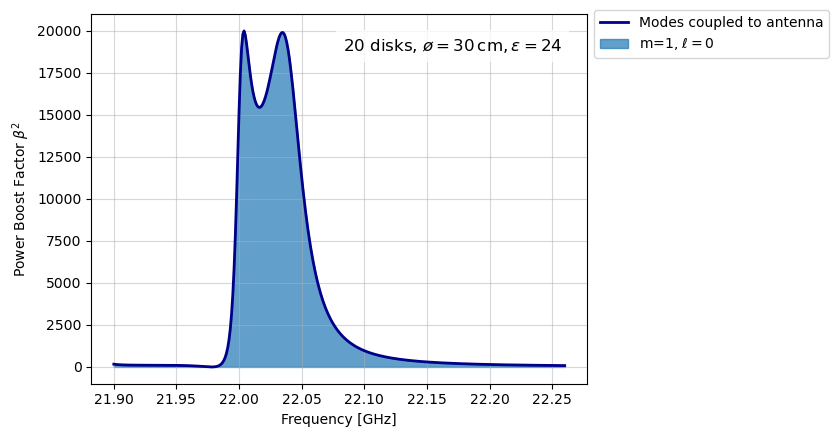

In [61]:
# Plot the power contained in each mode in a "stacked areas" plot

# Total power of modes iterated over / plotted so far
tot = zeros(length(EoutModes0[1,1,:]))
# Iterate over modes
for i in 1:(modes.M*(modes.L*2+1))
    # get (m,l) indices
    m = Int( floor((i-1)/(modes.L*2+1))+1 )
    l = (i-1)%(modes.L*2+1)-modes.L
    # create label
    labeling = (l > 0 ? "m=$m, \$\\ell=\\pm\$$l" : l == 0 ? "m=$m, \$\\ell=0\$" : nothing)
    
    # do the plotting
    fill_between(frequencies/1e9,tot, tot.+abs2.(EoutModes0[1,i,:]), alpha=0.7/(1+abs(l)), label=labeling, color="C$(m-1)")
    
    # update total power
    tot .+= abs2.(EoutModes0[1,i,:])
end

# Coupling to antenna beam
coupled_power = abs2.(sum(conj.(EoutModes0[1,:,:]).*m_reflect, dims=1)[1,:])
plot(frequencies/1e9, coupled_power, c="darkblue", linewidth=2, label="Modes coupled to antenna")

# Legend, Labels, etc.
legend(loc="upper left", bbox_to_anchor=(1, 1.03))
xlabel("Frequency [GHz]")
ylabel("Power Boost Factor \$\\beta^2\$")
grid(alpha=0.5)
textstring="20 disks, \$\\o = 30\\,{\\rm cm}, \\epsilon = 24\$"
text(0.95, 0.9, textstring, ha="right", fontsize=12, transform=gca().transAxes, bbox=Dict("facecolor" => "white", "alpha" => 0.8, "pad" => 5, "linewidth" => 0));


### Trace Back Fields Inside

#### Plot Fields Inside

In [177]:
"""
    Plot the fields inside the system for a 1D calculation
"""
function plot_1d_field_pattern(full_solution_regions, bdry::SetupBoundaries, f; fill=false,
    add_ea=false, overallphase=1)
    # Iterate over regions and plot the result in each region
    ztot = 0 # Each region needs to know where it starts, so iteratively add up the lengths of regions
    Nregions = length(bdry.eps) 
    for s in 1:Nregions
        # Propagation constant in that region
        c=299792458
        kreg = 2pi/c*f
        kreg *= sqrt(bdry.eps[s])
        
        # Define the color of that region according to mirror / disk / free space / ...
        fillcolor = nothing
        if abs.(bdry.eps[s]) > 100 || bdry.eps[s] == NaN
            fillcolor = "darkorange"
        elseif abs.(bdry.eps[s]) != 1
            fillcolor = "lightgray"
        end
        
        # Plot that region        
        plot_region_1d(full_solution_regions[s,1].*overallphase, full_solution_regions[s,2].*overallphase,
                        ztot, ztot+bdry.distance[s],
                        kreg,
                        Ea=(add_ea ? (1/bdry.eps[s]).*overallphase : 0),
                        maxE=2.2*maximum(abs.(full_solution_regions[:,:])),
                        bgcolor=fillcolor, extraspace=(s == Nregions),fill=fill,)
        
        ztot += bdry.distance[s]
    end
    
    # Add annotations to plot
    xlabel("z [m]")
    ylabel("\$E/E_0\$")
    
    legend(loc="lower right")
end

"""
    Plot the fields inside one region for a 1D calculation
"""
function plot_region_1d(R, L, z0, z1, k; bgcolor=nothing, extraspace=false,fill=false, Ea=0,maxE=10)    
    # Construct the relative coordinate system for that region
    z1 += 1e-9
    maximum = (z1+(extraspace ? 10e-3 : 0))
    z = vcat(z0:2e-4:maximum, maximum)
    dz = z .- z0
    dz2 = .-(z .- z1)
    
    # Calculate the functional solution for the region
    Rf = L*exp.(+1im.*k.*dz2)
    Lf = R*exp.(-1im.*k.*dz2)
    
    #Plot ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # Mark the Region as Disk / Mirror / Air / etc.
    if bgcolor != nothing
        fill_between([z0 == 0 ? -0.0025 : z0,z1], -maxE, maxE, color=bgcolor, linewidth=0)
    end
    
    # Plot the real and imaginary part of the solution
    plot(z, real.(Rf.+Lf.+ Ea), c="b", label=(extraspace ? "Re(E)" : ""))
    plot(z, imag.(Rf.+Lf.+ Ea), c="r", label=(extraspace ? "Im(E)" : ""))
end

"""
    Rotate the solution such that the fields inside are real
"""
function autorotate(full_solution_regions)
    ang = angle.(full_solution_regions[2,1].+full_solution_regions[2,2])
    #sgn = real.((full_solution_regions[2,1].+full_solution_regions[2,2]).*exp(-1im*ang)) .> 0
    return full_solution_regions.*exp(-1im*ang)
end

autorotate

The following cell contains the actual call to the `transformer_trace_back()` function and turns the result into a plot.

Remember, what is plotted is the field that is generated when doing a reflectivity measurement.

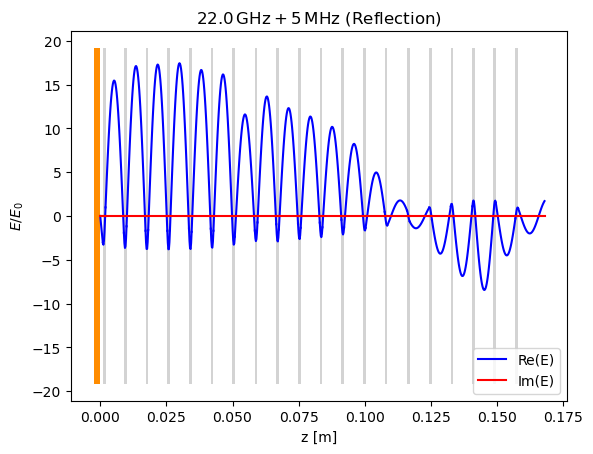

PyObject Text(0.5, 1.0, '$22.0\\,{\\rm GHz} + 5 \\,{\\rm MHz}$ (Reflection)')

In [183]:
using Printf

freq_idx = 106

full_fields = BoostFractor.transformer_trace_back(-EoutModes0[2,:,freq_idx], m_reflect, sbdry, coords,modes;
    prop=propagator1D,f=frequencies[freq_idx])
plot_1d_field_pattern(-autorotate(full_fields[:,:,1]), sbdry, frequencies[freq_idx])

frel = (frequencies[freq_idx]-22e9)
ft = @sprintf "%.0f" (frel)/1e6
if frel >= 0
    title("\$22.0\\,{\\rm GHz} + $ft \\,{\\rm MHz}\$ (Reflection)")
else
    title("\$22.0\\,{\\rm GHz}  $ft \\,{\\rm MHz}\$ (Reflection)")
end

Do the same with the fields caused by the axion

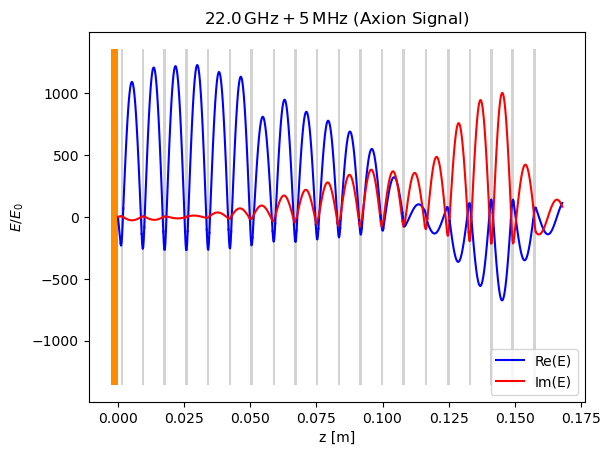

PyObject Text(0.5, 1.0, '$22.0\\,{\\rm GHz} + 5 \\,{\\rm MHz}$ (Axion Signal)')

In [192]:
using Printf

freq_idx = 106

full_fields = BoostFractor.transformer_trace_back(-EoutModes0[1,:,freq_idx], zeros(length(m_reflect)), sbdry, coords,modes;
    prop=propagator1D,f=frequencies[freq_idx], inlcudes_axion=true)
plot_1d_field_pattern((full_fields[:,:,1]), sbdry, frequencies[freq_idx], add_ea=true, overallphase=exp(-1im*pi/2*0.95))
# Notice that here we did not explicitly change the phase of full_fields,
# but use the argument of the plotting function overallphase
# to set it to something convenient for us
# This is because the plotting adds the axion-induced field, for which it needs to know the phase



frel = (frequencies[freq_idx]-22e9)
ft = @sprintf "%.0f" (frel)/1e6
if frel >= 0
    title("\$22.0\\,{\\rm GHz} + $ft \\,{\\rm MHz}\$ (Axion Signal)")
else
    title("\$22.0\\,{\\rm GHz}  $ft \\,{\\rm MHz}\$ (Axion Signal)")
end

#ylim(-3,3)
#xlim(-0.001,0.001)

Illustrate the argument of the "phase law": Complex conjugating, swapping (L, R) and then subtracting from the original solution up gives the same than the reflectivity case (up to phase and amplitude):

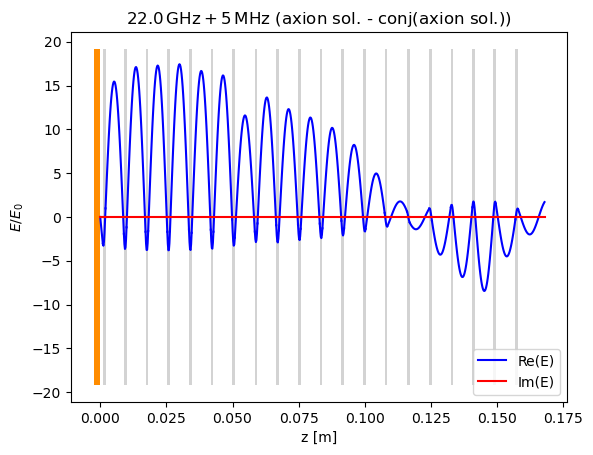

PyObject Text(0.5, 1.0, '$22.0\\,{\\rm GHz} + 5 \\,{\\rm MHz}$ (axion sol. - conj(axion sol.))')

In [186]:
using Printf

freq_idx = 106

# The usual solution we find, the boosted fields
full_fields_boost_out = BoostFractor.transformer_trace_back(-EoutModes0[1,:,freq_idx],
                                                  zeros(length(m_reflect))  , sbdry, coords,modes;
    prop=propagator1D,f=frequencies[freq_idx], inlcudes_axion=true)

# Swapping L and R, and complex conjugating
full_fields_boost_in = BoostFractor.transformer_trace_back( conj.(zeros(length(m_reflect))),
                                                  conj.(-EoutModes0[1,:,freq_idx]) , sbdry, coords,modes;
    prop=propagator1D,f=frequencies[freq_idx], inlcudes_axion=true)

# We subtract them to get rid of the axion-induced field (which is real)
full_fields = full_fields_boost_out .- full_fields_boost_in

# And plot the thing (automatically adjust phase and amplitude)
plot_1d_field_pattern(-autorotate(full_fields[:,:,1])/abs(EoutModes0[1,1,freq_idx]) , sbdry, frequencies[freq_idx])
# Note that the axion-induced field Ea - conj(Ea) = 0, so we do not care for it for the plot
# ... and can again shift the phase and scale accordingly as we want

fill_between([-0.0025,0], -10, 10, color="darkorange", linewidth=0)


frel = (frequencies[freq_idx]-22e9)
ft = @sprintf "%.0f" (frel)/1e6
if frel >= 0
    title("\$22.0\\,{\\rm GHz} + $ft \\,{\\rm MHz}\$ (axion sol. - conj(axion sol.))")
else
    title("\$22.0\\,{\\rm GHz}  $ft \\,{\\rm MHz}\$  (axion sol. - conj(axion sol.))")
end

#### Calculate the Overlap Integral

In [39]:
"""
    Calculate Boost Factor based on Overlap Integral Formalism for a 1D result
"""
function overlap_1d_field_pattern_minmax(full_solution_regions, bdry::SetupBoundaries, f)
    Nregions = length(bdry.eps) 
    
    Nregions = length(bdry.eps) 
    
    ot = 0 # Variable that sums up the total overalp
    
    
    c=299792458
    k0 = 2pi/c*f
    
    for s in 1:Nregions
        kreg = k0*sqrt(bdry.eps[s])
        
        ot += overlap_region_1d(full_solution_regions[s,1], full_solution_regions[s,2],
                        0, bdry.distance[s],kreg)       
    end
    
    s = Nregions    
    ld = c/f
    
    # The last region, assuming vaccuum, go through all possible B-field lengths
    alloverlaps = ot .+ [overlap_region_1d(full_solution_regions[s,1], full_solution_regions[s,2],
                        0, dz,k0) for dz in 0:2e-5:ld]
    
    return k0/2 * minimum(abs.(alloverlaps)), k0/2 * maximum(abs.(alloverlaps)) 
end

"""
    Calculate Boost Factor based on Overlap Integral Formalism for a 1D result
    In only one specific region
"""
function overlap_region_1d(R, L, z0, z1, k, bgcolor=nothing)
    dz2 = abs.(z0 - z1)
      
    Rt = L*exp.(+1im*k*dz2)
    Lt = R*exp.(-1im*k*dz2)
    
    return (Rt/(1im*k) + Lt/(-1im*k)) .- (L/(1im*k) + R/(-1im*k))    
end

# TODO: add some comments why L and R are swapped, for later reference at least, 
# when we will do it the right way...

overlap_region_1d (generic function with 2 methods)

Below the actual code that traces back the fields using the `transformer_trace_back()` function, then passes it to the helper function above to calculate the overlap integral from it, and then turns the result into a nice plot.

Notice again, the result that is used for the overlap integral from the initial `transformer()` call is only the initially calculated reflectivity and not the boost factor, i.e.:
 * we only use the fields inside generated during a reflection measurement to calculate the boost factor
 * if we know all boundary conditions perfectly well and do a reflection measurement, we can calculate the boost factor by tracing back fields (in practice this may be impossible...)

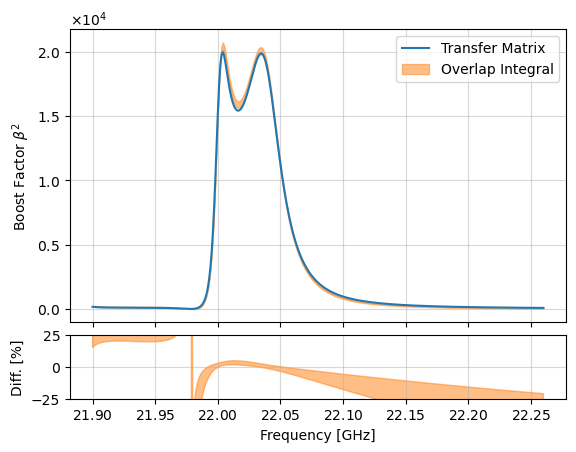

PyObject Text(25.35119018554689, 0.5, 'Diff. [%]')

In [182]:
# Calculate the beta^2 curve:
betas_min = zeros(length(frequencies))
betas_max = zeros(length(frequencies))
for idx in 1:length(frequencies)
    full_fields = BoostFractor.transformer_trace_back(-EoutModes0[2,:,idx], m_reflect, sbdry, coords, modes; 
        prop=propagator1D,f=frequencies[idx])
    betas_min[idx], betas_max[idx] = overlap_1d_field_pattern_minmax(full_fields[:,:,1], sbdry, frequencies[idx])
end

ax1 = subplot2grid((5,1),(0,0), rowspan=4)

fill_between(frequencies./1e9, abs2.(betas_min), abs2.(betas_max), label="Overlap Integral", alpha=0.5, color="C1")
plot(frequencies./1e9, abs2.(EoutModes0[1,1,:]), label="Transfer Matrix")
legend()
#yscale("log")

ylabel("Boost Factor \$\\beta^2\$")
ticklabel_format(axis="both", scilimits=(-2,2), useMathText=true)
grid(alpha=0.5)
gca().tick_params(labelbottom=false)  

subplot2grid((5,1),(4,0), rowspan=1, sharex=ax1)
fill_between(frequencies./1e9, (abs2.(betas_min).-abs2.(EoutModes0[1,1,:]))./abs2.(EoutModes0[1,1,:])*100,
                          (abs2.(betas_max).-abs2.(EoutModes0[1,1,:]))./abs2.(EoutModes0[1,1,:])*100, 
    label="Diff", alpha=0.5, color="C1")
ylim(-25,25)
grid(alpha=0.5)

xlabel("Frequency [GHz]")
ylabel("Diff. [%]")

#xlim(21.95,22.01)